## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
/Users/yiheng/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/yiheng/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/yiheng/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/yiheng/.local/lib/python3.7/site-packages/tensorflow/py

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp1(input_shape, output_units=10, num_neurons=[1000, 500, 200, 100, 50], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
from keras.layers import Dropout

"""
建立神經網路，並加入 dropout layer
"""
def build_mlp2(input_shape, output_units=10, num_neurons=[1000, 500, 200, 100, 50], drp_ratio=0.3):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = 1e-2
Dropout_EXP = 0.35

In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
#L2_EXP
keras.backend.clear_session() # 把舊的 Graph 清掉
print("Experiment with Regulizer = %.6f" % (L2_EXP))
model = build_mlp1(input_shape=x_train.shape[1:], l2_ratio=L2_EXP)
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

exp_name_tag = "exp-l2-%s" % str(L2_EXP)
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}



Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 1000)              3073000   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 500)               500500    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 200)               100200    
_________________________________________________________________
hidden_layer4 (Dense)        (None, 100)               20100     
_________________________________________________________________
hidden_layer5 (Dense)        (None, 50)                5050      
_________________________________________________________________
output (Dense)        

W0107 13:23:54.488214 4548058560 deprecation_wrapper.py:119] From /Users/yiheng/opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 221us/step - loss: 27.1031 - accuracy: 0.2271 - val_loss: 25.0428 - val_accuracy: 0.3121
Epoch 2/50
50000/50000 [==============================] - 10s 200us/step - loss: 23.2920 - accuracy: 0.3298 - val_loss: 21.6208 - val_accuracy: 0.3406
Epoch 3/50
50000/50000 [==============================] - 10s 205us/step - loss: 20.1377 - accuracy: 0.3534 - val_loss: 18.7193 - val_accuracy: 0.3596
Epoch 4/50
50000/50000 [==============================] - 10s 199us/step - loss: 17.4630 - accuracy: 0.3645 - val_loss: 16.2512 - val_accuracy: 0.3763
Epoch 5/50
50000/50000 [==============================] - 10s 200us/step - loss: 15.1808 - accuracy: 0.3753 - val_loss: 14.1454 - val_accuracy: 0.3798
Epoch 6/50
50000/50000 [==============================] - 10s 201us/step - loss: 13.2356 - accuracy: 0.3824 - val_loss: 12.3672 - val_accuracy: 0.3773
Epoch 7/50
50000/50000 [====================

In [9]:

#Dropout_EXP
keras.backend.clear_session() # 把舊的 Graph 清掉
print("Experiment with Regulizer = %.6f" % (Dropout_EXP))
model = build_mlp2(input_shape=x_train.shape[1:], drp_ratio=Dropout_EXP)
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM) #
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

exp_name_tag = "exp-Dropout-%s" % str(Dropout_EXP)
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}


Experiment with Regulizer = 0.350000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 1000)              3073000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 500)               500500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 200)               100200    
_________________________________________________________________
dropout_3 (Dropout)   

50000/50000 [==============================] - 9s 178us/step - loss: 1.5920 - accuracy: 0.4212 - val_loss: 1.4861 - val_accuracy: 0.4609
Epoch 43/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.5896 - accuracy: 0.4238 - val_loss: 1.4955 - val_accuracy: 0.4604
Epoch 44/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.5799 - accuracy: 0.4279 - val_loss: 1.4855 - val_accuracy: 0.4632
Epoch 45/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.5736 - accuracy: 0.4301 - val_loss: 1.5114 - val_accuracy: 0.4564
Epoch 46/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.5674 - accuracy: 0.4314 - val_loss: 1.4710 - val_accuracy: 0.4709
Epoch 47/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.5611 - accuracy: 0.4338 - val_loss: 1.4827 - val_accuracy: 0.4684
Epoch 48/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.5601 - accuracy: 0.4360 - val_loss:

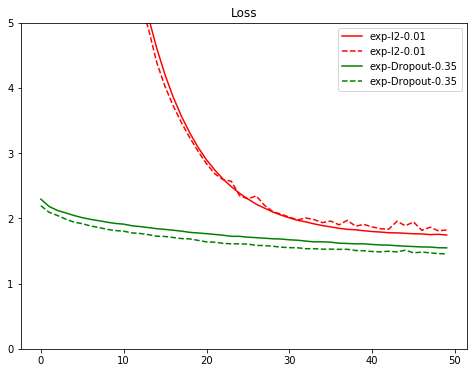

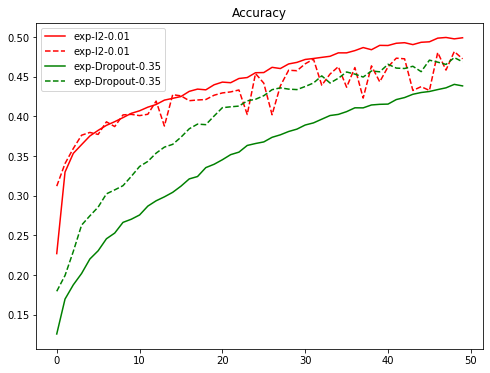

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()
